### Fitting XShooter data with xtool ###

In [1]:
from xtool.data import XShooterData, Order
from xtool.model import OrderModel, VirtualPixelWavelength, GenericBackground, MoffatTrace, SlopedMoffatTrace

from collections import OrderedDict
from scipy import sparse
from scipy import optimize
import numpy as np

#### Reading XShooter data ####

In [2]:
xd = XShooterData('xtool_ds/')

In [3]:
current_order = xd[17]
current_order.enable_flags_as_mask() # important to update the data to include the bad pixels from the pipeline

#### Generating a virtual pixel table for "Wavelength"-pixels ####

In [4]:
virt_pix = VirtualPixelWavelength.from_order(current_order, wavelength_sampling=0.03)
pixel_table = virt_pix()

#### Initializing the two Models ####

In [5]:
background_mdl = GenericBackground(pixel_table, virt_pix.wavelength_pixels)
trace_mdl = SlopedMoffatTrace(pixel_table, virt_pix.wavelength_pixels)

In [6]:
order_model = OrderModel([background_mdl, trace_mdl])

#### Show fittable parameters ####

In [7]:
order_model

<OrderModel(background_level=[    0.     0.  2023. ...,  2008.  2008.  2008.], amplitude=[ nan  nan  nan ...,  nan  nan  nan], trace_pos=0.0, trace_slope=0.0, sigma=1.0, beta=1.5 [f])>

#### Initializing the fitter ####

In [8]:
from xtool.model.fitters import Fitter

In [9]:
fitter = Fitter(order_model, current_order)

#### Differential Evolution fit ####

Differential evolution is a very thorough but slow processs. It does not use starting values but moves within the bounds of the parameters. 

In [31]:
order_model.beta.fixed = False
dresult = fitter.fit_differential_evolution(disp=True)

differential_evolution step 1: f(x)= 4.22785e+06
differential_evolution step 2: f(x)= 4.22785e+06
differential_evolution step 3: f(x)= 2.95083e+06
differential_evolution step 4: f(x)= 2.95083e+06
differential_evolution step 5: f(x)= 2.26008e+06
differential_evolution step 6: f(x)= 2.26008e+06
differential_evolution step 7: f(x)= 2.26008e+06
differential_evolution step 8: f(x)= 2.26008e+06
differential_evolution step 9: f(x)= 2.06608e+06
differential_evolution step 10: f(x)= 2.06231e+06
differential_evolution step 11: f(x)= 2.00095e+06
differential_evolution step 12: f(x)= 1.96445e+06
differential_evolution step 13: f(x)= 1.96445e+06
differential_evolution step 14: f(x)= 1.96445e+06
differential_evolution step 15: f(x)= 1.89723e+06
differential_evolution step 16: f(x)= 1.89723e+06
differential_evolution step 17: f(x)= 1.89723e+06
differential_evolution step 18: f(x)= 1.89723e+06
differential_evolution step 19: f(x)= 1.89654e+06
differential_evolution step 20: f(x)= 1.89654e+06
different

In [32]:
dresult

     fun: 1896544.4149950482
 message: 'Optimization terminated successfully.'
    nfev: 1425
     nit: 21
 success: True
       x: array([-2.44188896, -0.26832235,  0.19794569,  2.0046534 ])

#### Nelder Mead / Simplex ####

This one is much faster algorithm that will use starting values, but is unbounded

In [10]:
order_model.trace_pos = -2
order_model.sigma = 0.1
order_model.trace_slope = 0.
order_model.beta.fixed = False
order_model.beta = 2.0
result = fitter.fit_scipy_minimize('Nelder-Mead')

/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Fit finished in 851.559898853 s


/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [15]:
spec = order_model.model_list[1].to_spectrum()

Populating the interactive namespace from numpy and matplotlib


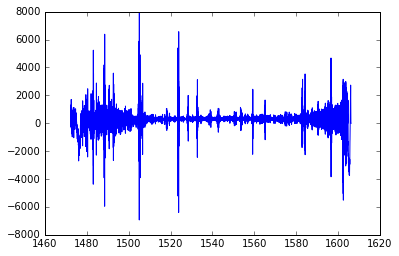

In [19]:
%pylab inline
plot(spec.wavelength, spec.flux)

#### Plotting in DS9 ####

In [11]:
import pyds9

In [12]:
d = pyds9.DS9()

In [14]:
order_model.trace_pos = result.x[0]
order_model.trace_slope = result.x[1]
order_model.sigma = result.x[2]
order_model.beta = result.x[3]
model = order_model.evaluate_to_frame(current_order, trace_pos=order_model.trace_pos, 
                                      trace_slope=order_model.trace_slope, sigma=order_model.sigma, 
                                      beta=order_model.beta.value)
d.set('frame 1')
d.set_np2arr(current_order.data.filled())

d.set('frame 2')
d.set_np2arr(model.filled())

d.set('frame 3')
d.set_np2arr((current_order.data.filled() - model.filled()) / current_order.uncertainty.filled())

1